# Notebook d'analyse exploratoire
- L'application que nous cherchons à mettre en place aura pour but de fournir le nutriscore d'un produit même si celui-ci ne l'affiche pas sur l'emballage.

- La solution privilégiée et la plus simple revient à trouver dans la base de donnée la valeur nutriscore associée au code d'un produit et de la renvoyer à l'utilisateur lorsque celui-ci scanne le produit.

- Cependant, comme vu précédemment, le nutriscore n'est disponible que pour une fraction des articles disponibles dans la base de données OpenFoodFacts.

- Nous allons à présent analyser les liens entre nutriscore et les autres variables dans le but de mitiger ce problème.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kendalltau

### Chargement des données en mémoire pour analyse
Nous travaillons sur les données nettoyées du premier notebook

In [2]:
data = pd.read_csv('data_clean.csv',sep='\t')

In [3]:
data.sample(10)

,fruits-vegetables-nuts_100g,salt_100g,fat_100g,proteins_100g,sugars_100g,saturated-fat_100g,energy_100g,KNN-imputed-fiber_100g,nutriscore_score,nutriscore_grade
2479,100.00,0.10,53.0,21.0,4.6,4.0,2547.0,9.90,-4.0,a
1733,78.00,0.12,0.0,0.4,39.0,0.0,922.0,2.60,6.0,c
3166,11.20,0.40,33.5,6.8,33.9,17.3,2038.0,1.90,23.0,e
3187,92.00,0.00,0.2,0.5,15.0,0.0,293.0,2.80,-4.0,a
281,8.00,0.17,3.3,3.5,12.6,2.3,405.0,0.35,3.0,c
1372,72.00,0.83,9.0,1.0,5.0,0.7,477.0,2.00,1.0,b
3057,100.00,0.00,49.5,24.5,6.5,6.5,2536.0,10.50,-1.0,a
2748,15.89,0.80,1.1,5.0,0.8,0.2,153.0,0.80,0.0,b
981,80.00,0.29,0.5,2.7,0.8,0.1,198.0,3.70,-5.0,a
1221,79.00,0.03,0.5,0.2,9.0,0.0,173.0,0.10,8.0,d


## Analyse univariée
### Nous allons faire une analyse univariée pour chacune des variables de notre jeu de données

Definition de la fonction d'analyse et de visualisation

In [4]:
# cette fonction renvoie 'non' si la variable ne suit pas une distribution normale et 'oui' le cas inverse
def norm_test(values):
    k2, p = stats.normaltest(values)
    alpha = 0.05 
    if p < alpha:  # H0 data[column] est normale
        return 'non'
    else:
        return 'oui'

In [5]:
plt.style.use('seaborn-darkgrid')
def plot_summary(data):
    n_col = len(data.columns)
    fig, ax = plt.subplots(n_col,2,
                           figsize=(13,18),
                           gridspec_kw={'width_ratios':[6,1]})  
    title = plt.suptitle('Analyse univariée des déterminants du nutriscore',
                fontsize=20)
    title.set_position([0.55,0.93])
    plt.subplots_adjust(hspace=0.5)
    ax[0,0].set_title('Distribution',fontsize=15)
    ax[0,1].set_title('Statistiques descriptives',fontsize=15)
    for i in range(0,n_col):
                   plot_data = data.iloc[:,i]
                   mean = np.round(plot_data.mean(),2)
                   median = np.round(plot_data.median(),2)
                   std = np.round(plot_data.std(),2)
                   is_norm = norm_test(plot_data)
                   sns.boxplot(ax = ax[i,0], x= plot_data)
                   ax[i,1].axis('off')
                   ax[i,1].text(s=f'moyenne = {mean}',x=-0.35,y=0.75)
                   ax[i,1].text(s=f'écart-type = {std}',x=-0.35,y=0.55)
                   ax[i,1].text(s=f'médiane = {median}',x=-0.35,y=0.35)
                   ax[i,1].text(s=f'distribution normale = {is_norm}',x=-0.35,y=0.01)

On construit un jeu de données sans la note du nutriscore en lettres pour nos analyses

In [6]:
num_data = data.drop('nutriscore_grade',axis=1) 

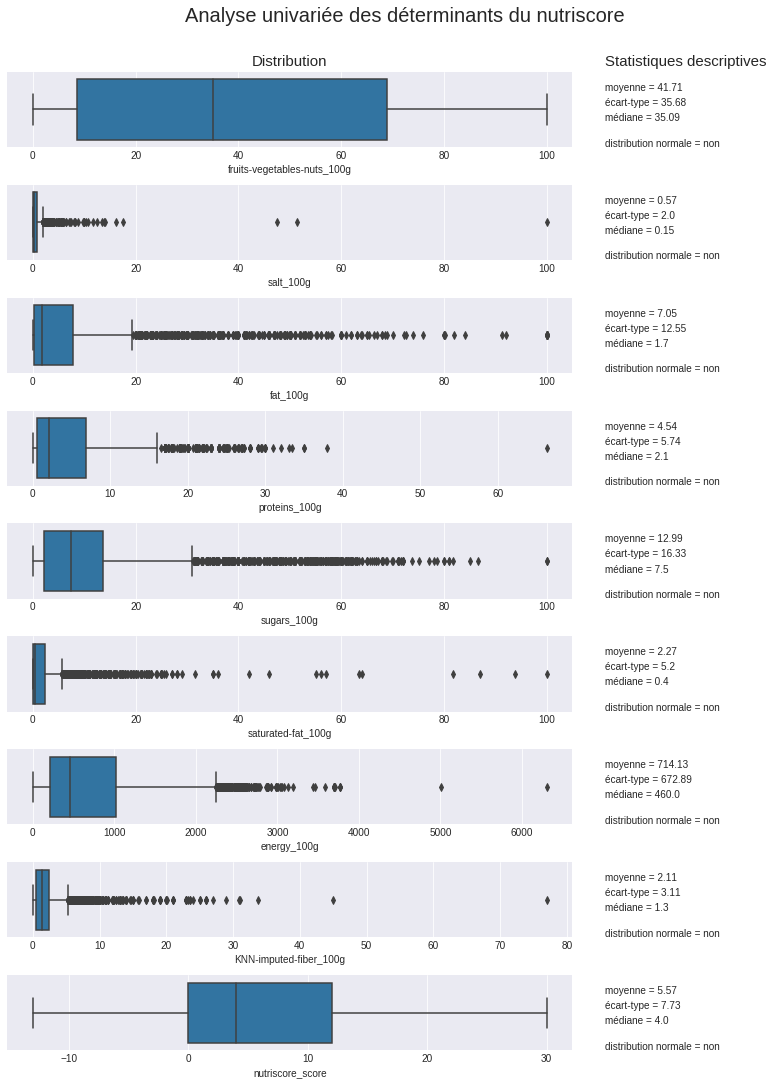

In [7]:
plot_summary(num_data)

Aucune des variables de notre jeu de données est normalement distribuée

## Analyse bivariée
### Liens entre NutriScore et mesures nutritives
Quelle relation le nutriscore entretient-il avec les autres variables ?

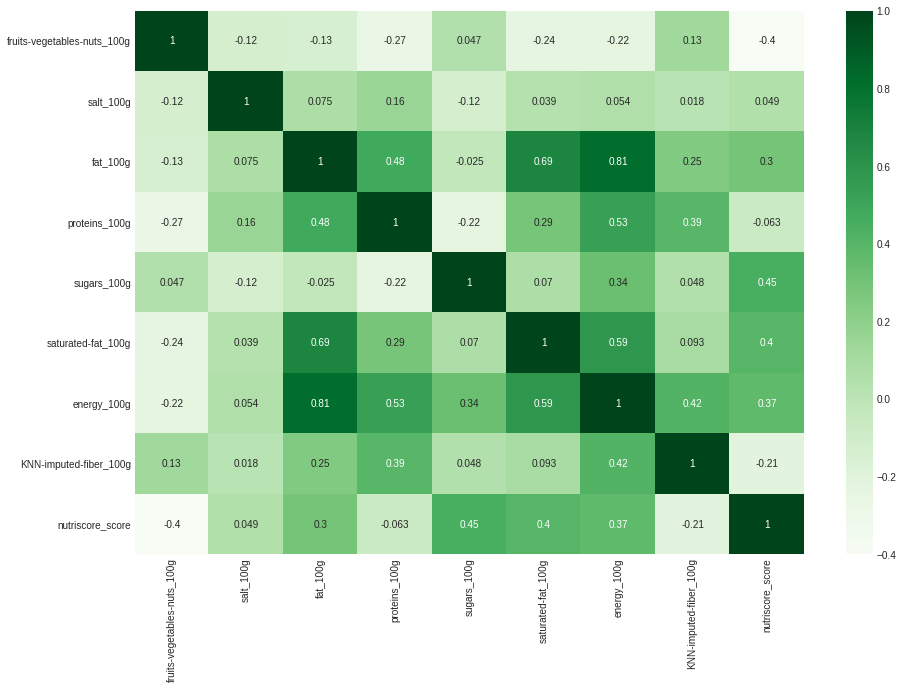

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(num_data.corr(),
            annot=True,
            cmap='Greens');

Etant donné qu'au plus le nutriscore augmente, au moins l'aliment est considéré bon pour la santé nous pouvons déjà différencier les bons des mauvais nutriments :
- une correlation négative représente un nutriment à consommer
- une correlation positive représente un nutriment à éviter

On peut voir ici que le nutriscore est :

négativement corrélé aux :
- fruits / légumes / fruits à coque
- fibres
- protéines (très faiblement)

positivement corrélé aux :
- graisses
- sucres
- graisses saturées
- calories
- sel (très faiblement)

Nous savons, grâce à nos recherches sur le nutriscore, que le sel et les protéines jouent un rôle dans son calcul.
- Les corrélations entre ces nutriments et le score sont cependant très faibles 

Nous pouvons tester la significativité de ce lien

In [9]:
def corr_test(series1,series2):
    pvalue = kendalltau(series1,series2).pvalue
    if pvalue < 0.05:
        print('Les variables sont significativement corrélées')
    elif pvalue >= 0.05:
        print('les varialbes ne sont pas significativement corrélées')

Corrélation entre protéines et nutriscore

In [10]:
corr_test(data['proteins_100g'],data['nutriscore_score'])

Les variables sont significativement corrélées


Corrélation entre sel et nutriscore

In [11]:
corr_test(data['salt_100g'],data['nutriscore_score'])

Les variables sont significativement corrélées


#### Bien que faible la corrélation semble significative.

## Analyse multivariée
#### Nous allons maintenant effectuer une **analyse factorielle** afin de mieux comprendre les liens entre valeurs nutritionnelles et nutriscore.

### Factorisation des données
Nous décomposons nos données en plusieurs facteurs afin de regrouper ensembles les variables similaires

Avant d'extraire les facteurs nous standardisons les données.

In [12]:
scaled_data = ((num_data - num_data.mean(axis=0) ) / num_data.std()).values

Calcul des facteurs latents par SVD
- cette opération va nous permettre de représenter les données sous une forme plus dense en informations.

In [13]:
U, S, Vt = np.linalg.svd(scaled_data)

Projection des individus sur les facteurs

In [14]:
projection = scaled_data.dot(Vt.T)

Définition de variables nécessaires à l'analyse

In [15]:
# la quantité d'individus analysés
n_samples = U.shape[0] 
# la variance expliquée par chaque composante
explained_variance = (S ** 2)/ (n_samples - 1) 
# la variance totale expliquée
total_var = explained_variance.sum() 
# la proportion de variance expliquée par composante
explained_variance_ratio = explained_variance / total_var 
# le nom des variables
variables = num_data.columns.values

### Interprétation des facteurs

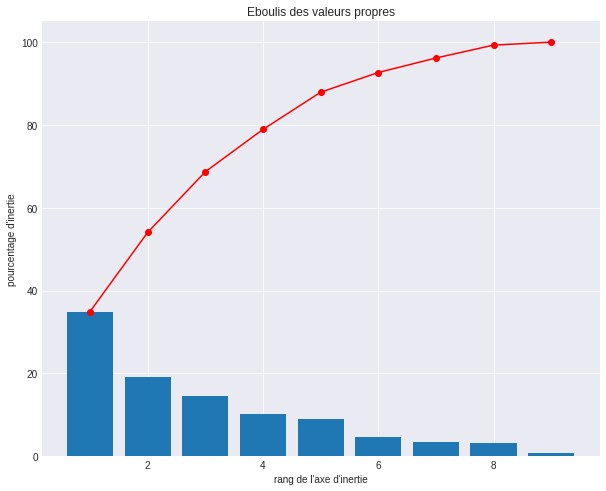

In [16]:
scree = explained_variance_ratio*100
plt.figure(figsize=(10,8))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On peut voir ici que deux facteurs expliquent environ 50% de la variabilité
* avec 4 facteurs nous pouvons résumer 80% de la variabilité

Tentons de comprendre les relations entre ces facteurs, les individus et les variables à travers des visualitions.

In [17]:
# fonction de visualisation des variables et individus projettés sur les plans factoriels
def plot_pca(F1,F2):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    # titre général de la figure
    fig.suptitle('Analyse en composantes principales',fontsize=19)
    
    ## sous figure 1 : projection des individus sur le plan factoriel
    
    # Reconstitution du code couleur nutriscore
    palette = {"a":"forestgreen",
               "b":"yellowgreen",
               'c':"yellow",
               'd':'orange',
               'e':"firebrick"}
    # nom des axes avec le pourcentage d'inertie (les deux sous graphes utilisent les mêmes noms d'axes)
    xlabel = f'Facteur {F1+1} ({np.round(explained_variance_ratio[F1]*100,2)}%)'
    ylabel = f'Facteur {F2+1} ({np.round(explained_variance_ratio[F2]*100,2)}%)'
    
    # titre du sous graphique
    ax[0].set_title(f'Projection des individus et leur classe NutriScore \n sur les plans factoriels {F1+1} et {F2+1}')
    
    # les individus projettés sur 2 plans factoriels
    x_proj = projection[:,F1]
    y_proj = projection[:,F2]
    
    # définition des limites du graphe: légèrement plus grande que les valeurs extrêmes
    xMaxLim, xMinLim = max(x_proj) +1, min(x_proj) -1
    yMaxLim, yMinLim = max(y_proj) +1, min(y_proj) -1
    ax[0].set_xlim(xMinLim,xMaxLim)
    ax[0].set_ylim(yMinLim,yMaxLim)
    
    # définition des noms des axes pour la figure 1 
    ax[0].set_xlabel(xlabel,fontsize=15)
    ax[0].set_ylabel(ylabel,fontsize=15)
    
    # construction du scatterplot
    sns.scatterplot(x=x_proj,y=y_proj,
                alpha=0.5,
                hue = data['nutriscore_grade'],
                palette=palette,
                ax=ax[0])
    # on fait passer deux lignes au centre du nuage de points pour aider l'interprétation avec les flèches de la seconde figure
    ax[0].plot([xMinLim,xMaxLim], [0, 0], color='grey', ls='--')
    ax[0].plot([0, 0], [yMinLim,yMaxLim], color='grey', ls='--')
    
    # On ordonne les lettres de la légende pour qu'elles soient dans le même ordre que le label nutriscore
    handles,labels = ax[0].get_legend_handles_labels()
    handles = [handles[3], handles[4], handles[2], handles[0],handles[1]]
    labels = [labels[3], labels[4], labels[2], labels[0], labels[1]]
    ax[0].legend(handles,labels,loc=3, title = 'Classe NutriScore')
    
    ## sous figure 2 : projection des variables sur le plan factoriel
    
    # definition du titre
    ax[1].set_title(f'Projection des variables \n sur les plans factoriels {F1+1} et {F2+1}')
    
    # Le centre du cercle est défini par le croisement de deux lignes orthogonales représentant les axes des facteurs comme sur la sous figure 1
    ax[1].plot([-1, 1], [0, 0], color='grey', ls='--')
    ax[1].plot([0, 0], [-1, 1], color='grey', ls='--')
    
    # définition des limites du graphe
    ax[1].set_xlim(-1,1)
    ax[1].set_ylim(-1,1)
    
    # On ne précise que le label x car le label y est le même sur la sous figure 1 et partage le même axe horizontal
    ax[1].set_xlabel(xlabel,fontsize=15)
    
    # définition du cercle et ajout des flèches des varaibles en fonction de leur corrélation avec le facteur
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
    ax[1].add_patch(circle)
    # la matrice Vt contient dans chaque ligne les correlations de toutes les variables pour 1 facteur
    # les lignes 1 et 2 correspondent aux correlations entre les variables et les facteurs 1 et 2 
    ax[1].quiver(np.zeros(Vt.shape[1]),
                 np.zeros(Vt.shape[1]),
                 Vt[F1,:],
                 Vt[F2,:],
                 angles='xy',
                 scale_units='xy',
                 scale=1,
                 alpha=0.3)
    
    # Nous utilisons les coordonnés des flèches pour y annoter le nom de chaque variable et ainsi interpréter les flèches
    for i in range(0,len(variables)):
        ax[1].text(Vt[F1,i],Vt[F2,i],
                 variables[i],
                 fontsize=14)

### Visualisation des deux premiers plans 
(environ 50% de l'information)

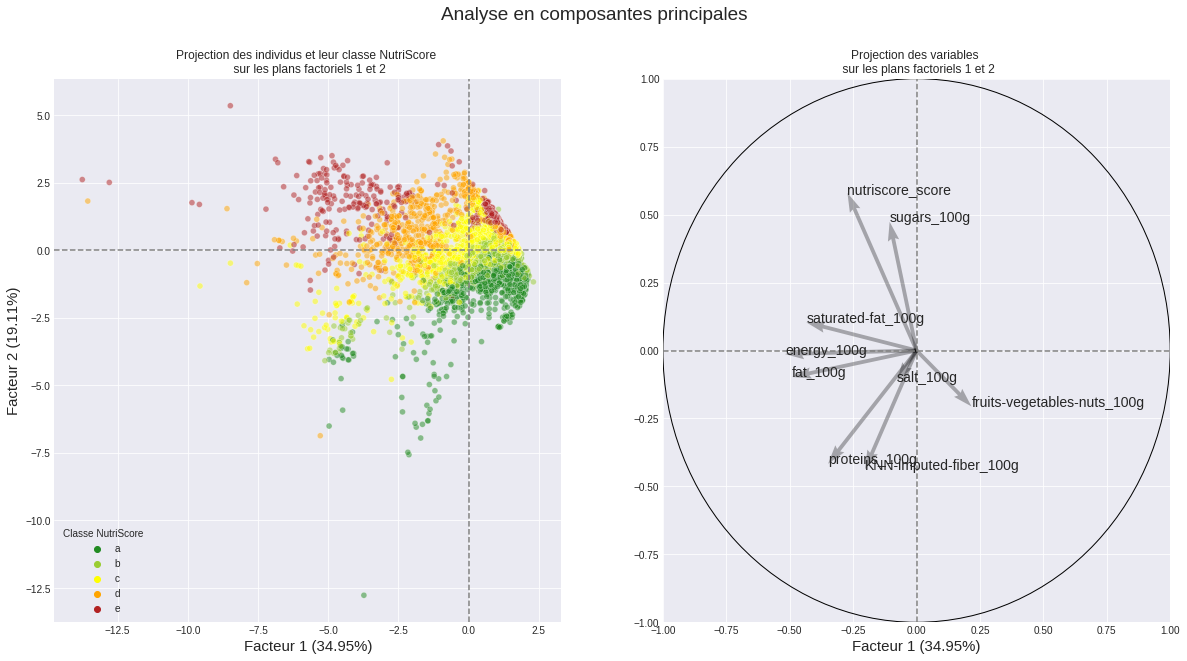

In [18]:
plot_pca(0,1)

Nous pouvons voir ici que :
- Le facteur 1 est négativement lié aux graisses de manière générale : saturées et simple ainsi que l'énergie qui est fortement liée à la graisse
- le facteur 2 est positivement lié au sucre et au nutriscore

Ce plan offre de bonnes capacités de clustering du nutriscore, on y voit les différentes catégories nutritives se découper assez nettement:
- en haut à gauche se trouvent des aliments plutôt gras et sucrés et celà correspond à la direction d'une augmentation du nutriscore et donc une moins bonne note (rouge foncé)

- à l'opposé, en bas à droite nous pouvons voir des aliments avec une bonne note (vert foncé), peu sucrés, peu gras et avec une bonne proportion de fruits/légumes/fruits à coque

- en bas à gauche nous pouvons voir une plus grande diversité dans les produits, ce sont les produits riches en protéines et en fibres. En bas à droite ce cette zone les produits sont bien notés par le nutriscore. Au fur et à mesure que l'on se déplace vers le haut et à gauche le score chute. Il semblerait que cette baisse de qualité nutritive soit due à une augmentation en graisse, sucre et une diminution en fruits/légumes/ fruits à coque. Peut être une transition vers des fibres/protéines animales et non végétales.

- en haut à droite un autre cluster d'aliments au mauvais profil nutritif se découpe. Peu gras mais sucrés, avec peu de fibres et protéines. Probablement des confiseries.

## Conclusion

Nous pouvons observer que la quantité de variables liées à un mauvais nutriscore sont plus nombreuses et disponibles que celles liées à des aliments sains.
* Dans l'éventualité où l'application ne serait pas en mesure de fournir le nutriscore il semblerait tout de même possible d'utiliser les variables plus accessibles comme les calories et le sucre pour décourager l'achat de certains produits.
* La mise en place d'un test nutriscore complet pour tous les produits nécessiterait des méthodes d'acquisition de données beaucoup plus poussées que des requettes à OpenFoodFacts  
- par exemple : l'extraction de la quantité de fruits / légumes / fruits à coque depuis une photo de la liste des ingrédients.